# Mean Force Integration in 1D

Import HILLS and COLVAR files, compute the mean force and integrate using the pyMFI (would be) module. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
if 'path' in locals():
    os.chdir(path)
    print(path)
else: 
    os.chdir("../")
    path = os.getcwd()
    print(path)
from pyMFI import MFI1D
from pyMFI import run_plumed
os.chdir(path + "/DATA_examples/1D_double_well")

/home/ucecabj/Desktop/pyMFI_git


### Double Well Potential
Langevin simulation on analytical potential: y = 7*x^4-23*x^2

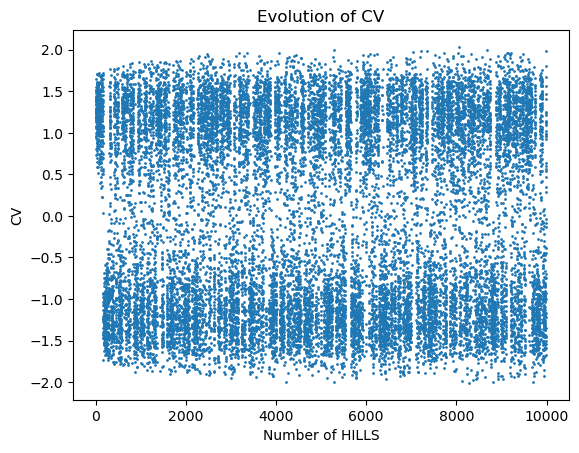

In [13]:
os.chdir(path + "/DATA_examples/1D_double_well")

# # Run simulation with Plumed
# run_plumed.run_langevin1D(simulation_steps = 2_000_000, initial_position=1.7, gaus_width=0.1, gaus_height=0.5, biasfactor=10)

#Read the HILLS file
HILLS=MFI1D.load_HILLS(hills_name="HILLS")

#Plot CV of HILLS
plt.scatter(HILLS[:,0],HILLS[:,1], s=1)
plt.xlabel("Number of HILLS"); plt.ylabel("CV"); plt.title("Evolution of CV"); plt.show()

20.0 %   OFE = 30.3596
40.0 %   OFE = 30.749
60.0 %   OFE = 30.4795
80.0 %   OFE = 30.2799
100.0 %   OFE = 30.278


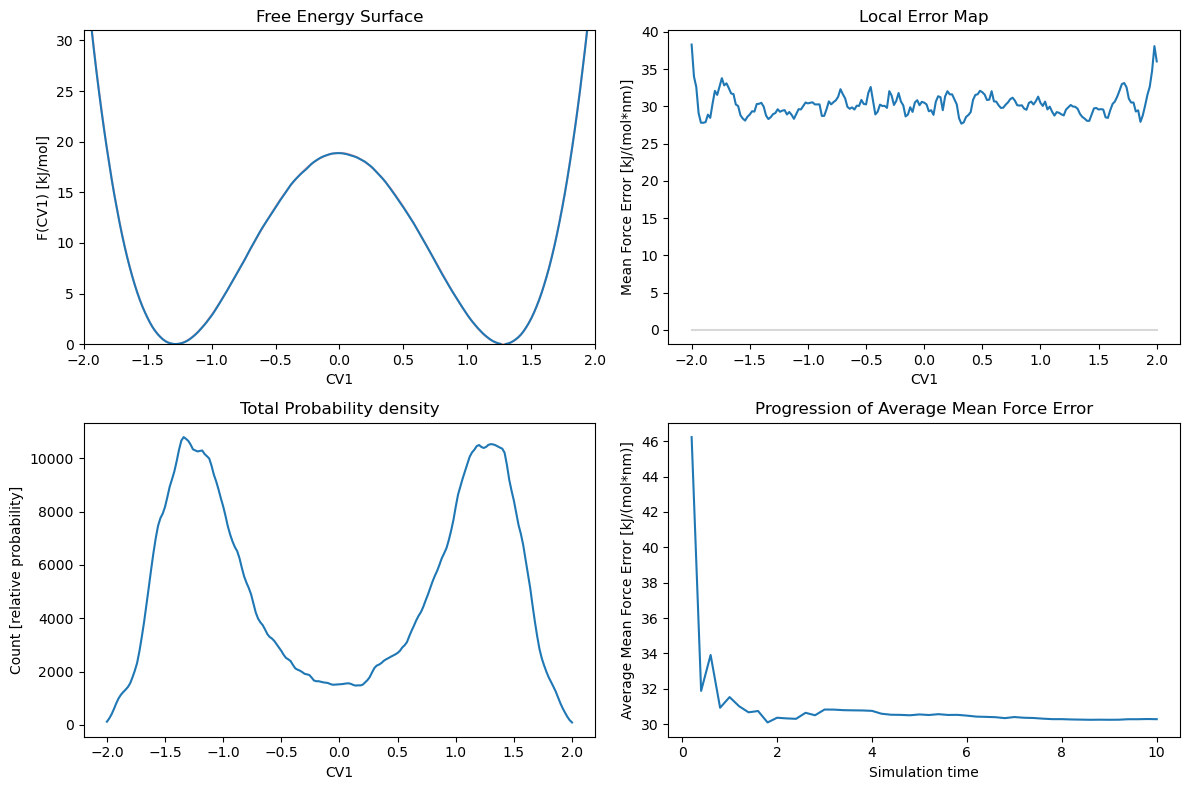

In [14]:
### Analyse simulation with Mean Force Integration
os.chdir(path + "/DATA_examples/1D_double_well")

#Read the HILLS file
HILLS=MFI1D.load_HILLS(hills_name="HILLS")

#Read the Colvar File
position = MFI1D.load_position(position_name="position")

#Compute the time-independent mean force
results = MFI1D.MFI_1D(HILLS = HILLS, position = position, bw = 0.02, kT = 1, min_grid=-2.0, max_grid=2.0, nhills=-1)
X, Ftot_den, Ftot_den2, Ftot, ofv_num, FES, ofv, ofe, cutoff, error_evol, fes_error_cutoff_evol = results

# Plot Recap
MFI1D.plot_recap(X, MFI1D.zero_to_nan(FES), MFI1D.zero_to_nan(Ftot_den), MFI1D.zero_to_nan(ofe), error_evol[1,:], error_evol[3,:], FES_lim=31, ofe_lim = 15, error_log_scale=0)
plt.show()

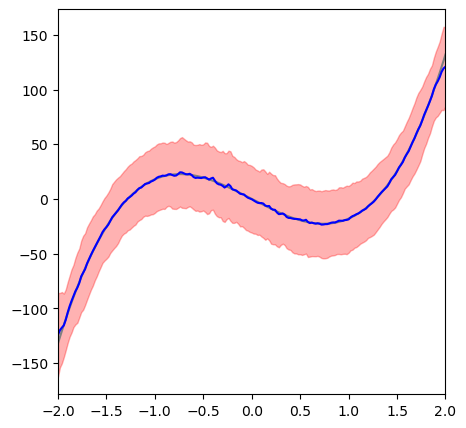

In [15]:
#Plot force and statistical error
F = 7*X**4-23*X**2
F = F - min(F)
Ff = 28*X**3 - 46*X

plt.figure(figsize=(5,5))
plt.plot(X,Ff, color="grey")
plt.plot(X, MFI1D.zero_to_nan(Ftot*cutoff), color="blue")
plt.fill_between(X, Ftot+MFI1D.zero_to_nan(ofe*cutoff), Ftot-MFI1D.zero_to_nan(ofe*cutoff), color="red", alpha=0.3)
# plt.fill_between(X, MFI1D.zero_to_nan(Ftot*cutoff), Ftot+MFI1D.zero_to_nan(ofe*cutoff)/2, color="black", alpha=0.3)
plt.xlim(-2,2)
plt.show()

In [3]:
# results_path = "/home/antoniu/Desktop/MFI_git/MFI_master/MFI/results_plot"

# MFI1D.save_pkl([X, F, Ff,  MFI1D.zero_to_nan(FES*cutoff), MFI1D.zero_to_nan(Ftot*cutoff), MFI1D.zero_to_nan(ofe*cutoff), ofe_history, time_history], results_path + "/MFI1D_results.pkl")


### Analysing the nucleation of a Lennard-Jones fluid
Simulating the nucleation of a fluid is a rare event problem. In a system with few particles, the chance of observing a nucleation is very small, but with a increasing system size, the computation cost becomes overwhelming. This problem becomes even more complicated due to the difference in biasing required for the forward path (nucleation) and the backward path (melting/sublimation).

To takle this problem, 100 independent simulations were performed:

    - 50 in the forward direction using small MetaD hills with and a static bias.
    
    - 50 in the backward direction using large MetaD hills.

Using MFI, all simulations can be patched together and the local Mean Force and FES can be found. 

(Only the first 5 forward and backward HILLS and COLVAR files are provided. The other files have been analysed already, and mean force, as well as other relevent force terms, can be found in the "pyMFI_git/DATA_examples/1D_LJ_T6n55/force_terms" folder)

In [2]:
path_back = path + "/DATA_examples/1D_LJ_T6n55/data_backward/"
path_forw = path + "/DATA_examples/1D_LJ_T6n55/data_forward/"
path_forceterms = path + "/DATA_examples/1D_LJ_T6n55/force_terms/"

100.0 %   OFE = 0.47
100.0 %   OFE = 2.6677
100.0 %   OFE = 0.4735
100.0 %   OFE = 2.5627
100.0 %   OFE = 0.4656
100.0 %   OFE = 2.6075
100.0 %   OFE = 0.474
100.0 %   OFE = 2.6283
100.0 %   OFE = 0.5034
100.0 %   OFE = 2.6399


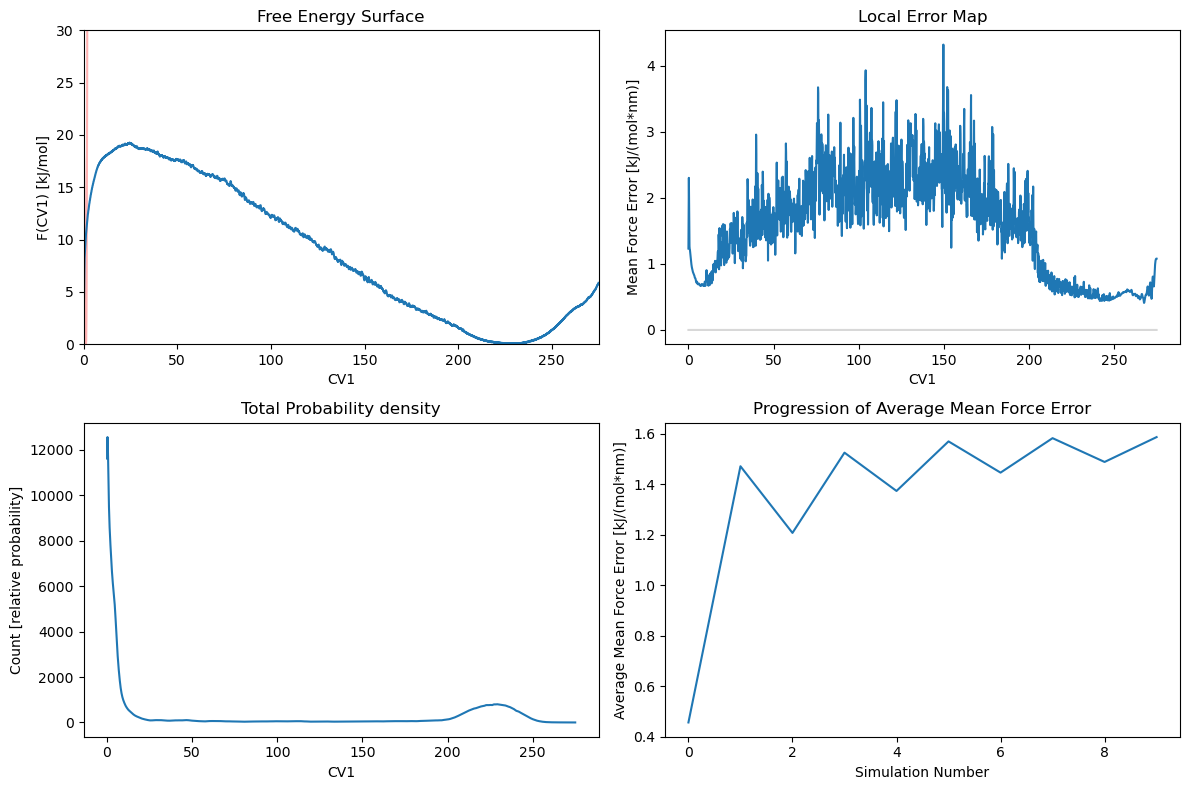

In [4]:
os.chdir(path + "/DATA_examples/1D_LJ_T6n55")

# Load the static bias
bias_force = MFI1D.load_pkl(path_forw + "negativebias")
all_forceterms = []

for i in range(1,6):
    
    #~~~ FORWARD ~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    #Read the HILLS file
    HILLS=MFI1D.load_HILLS(hills_name=path_forw + "HILLS_" + str(i))

    #Read the Colvar File
    position = MFI1D.load_position(position_name=path_forw + "COLVAR_" + str(i))

    #Compute the time-independent mean force
    results = MFI1D.MFI_1D(HILLS = HILLS, position = position, bw = 0.5, kT = 0.6, min_grid=0, max_grid=275, nbins=2201, log_pace=len(HILLS), F_static=bias_force)
    X, Ftot_den, Ftot_den2, Ftot, ofv_num, FES, ofv, ofe, cutoff, error_evol, fes_error_cutoff_evol = results

    #save force terms
    all_forceterms.append([Ftot_den, Ftot_den2, Ftot, ofv_num])
    MFI1D.save_pkl( [Ftot_den, Ftot_den2, Ftot, ofv_num], path_forceterms + "forces_forw_" + str(i) )
    
    #~~~ BACKWARD ~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        
    # #Read the HILLS file
    HILLS=MFI1D.load_HILLS(hills_name=path_back + "HILLS_" + str(i))

    #Read the Colvar File
    position = MFI1D.load_position(position_name=path_back + "COLVAR_" + str(i))

    #Compute the time-independent mean force
    results = MFI1D.MFI_1D(HILLS = HILLS, position = position, bw = 0.5, kT = 0.6, min_grid=0, max_grid=275, nbins=2201, log_pace=len(HILLS), F_static=np.zeros(len(X)))
    X, Ftot_den, Ftot_den2, Ftot, ofv_num, FES, ofv, ofe, cutoff, error_evol, fes_error_cutoff_evol = results

    #save force terms
    all_forceterms.append([Ftot_den, Ftot_den2, Ftot, ofv_num])
    MFI1D.save_pkl( [Ftot_den, Ftot_den2, Ftot, ofv_num], path_forceterms + "forces_back_" + str(i) )

     
#patch all forces
Ftot_den, Ftot_den2, Ftot, ofv_num, ofe, Aofe = MFI1D.patch_forces_ofe(np.asarray(all_forceterms), ofe_progression=True)

#Integrate patched mean force
FES = MFI1D.intg_1D(Ftot, X[1]-X[0])
    
# Plot Recap
MFI1D.plot_recap(X, MFI1D.zero_to_nan(FES), MFI1D.zero_to_nan(Ftot_den), MFI1D.zero_to_nan(ofe), Aofe, range(len(Aofe)), FES_lim=30, ofe_lim = 15, error_log_scale=0)
plt.xlabel("Simulation Number"); plt.show()

### Load all forces

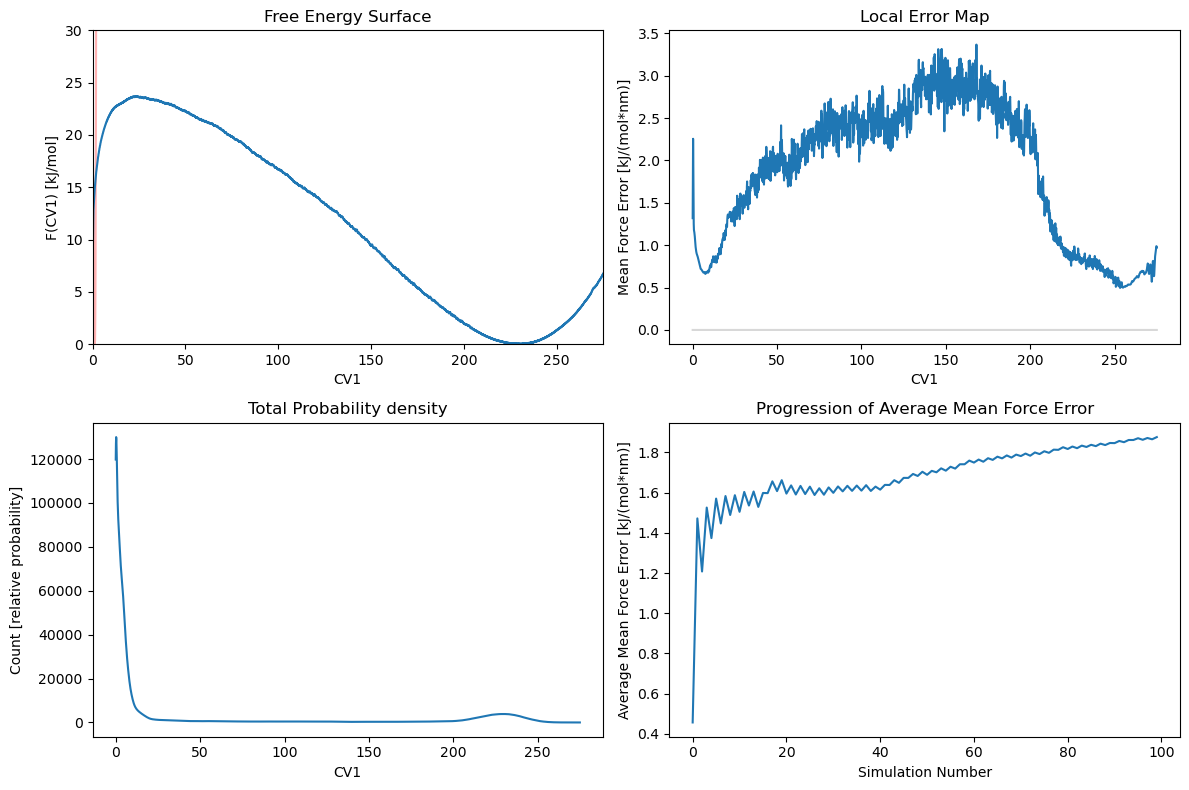

In [3]:
os.chdir(path + "/DATA_examples/1D_LJ_T6n55")
all_forceterms = []
min_grid=0; max_grid=275; nbins=2201; X = np.linspace(min_grid, max_grid, nbins)

for i in range(1,51):
    #~~~ FORWARD 
    all_forceterms.append(MFI1D.load_pkl(path_forceterms + "forces_forw_"+str(i)) )
    
    #~~~ BACKWARD 
    all_forceterms.append(MFI1D.load_pkl(path_forceterms + "forces_back_"+str(i)) )

  
#patch all forces
Ftot_den, Ftot_den2, Ftot, ofv_num, ofe, Aofe = MFI1D.patch_forces_ofe(np.asarray(all_forceterms), ofe_progression=True)

#Integrate patched mean force
FES = MFI1D.intg_1D(Ftot, X[1]-X[0])
    
# Plot Recap
MFI1D.plot_recap(X, MFI1D.zero_to_nan(FES), MFI1D.zero_to_nan(Ftot_den), MFI1D.zero_to_nan(ofe), Aofe, range(len(Aofe)), FES_lim=30, ofe_lim = 15, error_log_scale=0)
plt.xlabel("Simulation Number"); plt.show()

### Bootstrap error

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
if 'path' in locals():
    os.chdir(path)
    print(path)
else: 
    os.chdir("../")
    path = os.getcwd()
    print(path)
from pyMFI import MFI1D
from pyMFI import run_plumed
os.chdir(path + "/DATA_examples/1D_double_well")

path_forceterms = path + "/DATA_examples/1D_LJ_T6n55/force_terms/"

/home/ucecabj/Desktop/pyMFI_git


Itteration: 50 - sd: 0.65402
Itteration: 100 - sd: 0.60136
Itteration: 150 - sd: 0.64243
Itteration: 200 - sd: 0.63551
Itteration: 250 - sd: 0.64368
Itteration: 300 - sd: 0.6384
Itteration: 350 - sd: 0.6302
Itteration: 400 - sd: 0.63344
Itteration: 450 - sd: 0.64695
Itteration: 500 - sd: 0.65298


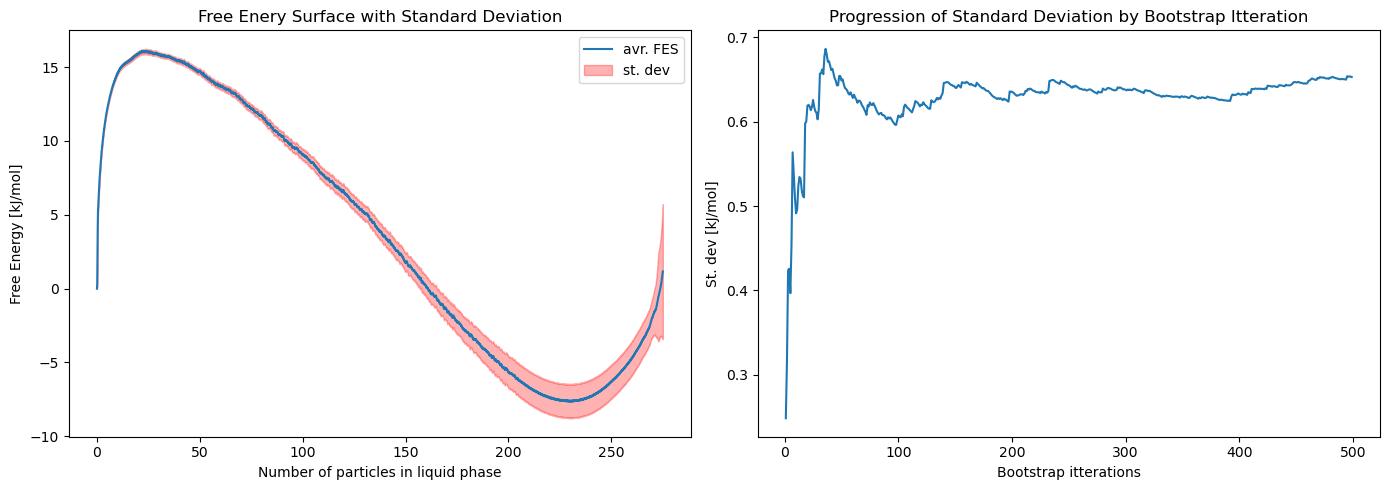

In [2]:
os.chdir(path + "/DATA_examples/1D_LJ_T6n55")

#initialise force list and grid
forceterms_forw = []
forceterms_back = []
min_grid=0; max_grid=275; nbins=2201; X = np.linspace(min_grid, max_grid, nbins)

#load force terms
for i in range(1,51):
    [Ftot_den, Ftot_den2, Ftot, ofv_num] = MFI1D.load_pkl(path_forceterms + "forces_forw_"+str(i))
    forceterms_forw.append( [Ftot_den, Ftot] )
    [Ftot_den, Ftot_den2, Ftot, ofv_num] = MFI1D.load_pkl(path_forceterms + "forces_back_"+str(i))
    forceterms_back.append( [Ftot_den, Ftot] )
    
#Boostrap
[FES_avr, sd_fes, sd_fes_prog ] = MFI1D.bootstrap_forw_back(X, np.asarray(forceterms_forw), np.asarray(forceterms_back), n_bootstrap=500, set_fes_minima="first_value")
    
#Plot
plt.figure(figsize=(14,5)); plt.subplot(1,2,1)
plt.plot(X, FES_avr, label="avr. FES")
plt.fill_between(X, FES_avr - sd_fes, FES_avr + sd_fes, alpha=0.3, color="red", label="st. dev")
plt.xlabel("Number of particles in liquid phase"), plt.ylabel("Free Energy [kJ/mol]"); plt.legend(); plt.title("Free Enery Surface with Standard Deviation")


plt.subplot(1,2,2)
plt.plot(range(len(sd_fes_prog)), sd_fes_prog)
plt.xlabel("Bootstrap itterations"), plt.ylabel("St. dev [kJ/mol]"); plt.title("Progression of Standard Deviation by Bootstrap Itteration"); plt.tight_layout()

### Bootstrap Error without forward and backward forces

Itteration: 50 - sd: 0.54632
Itteration: 100 - sd: 0.53848


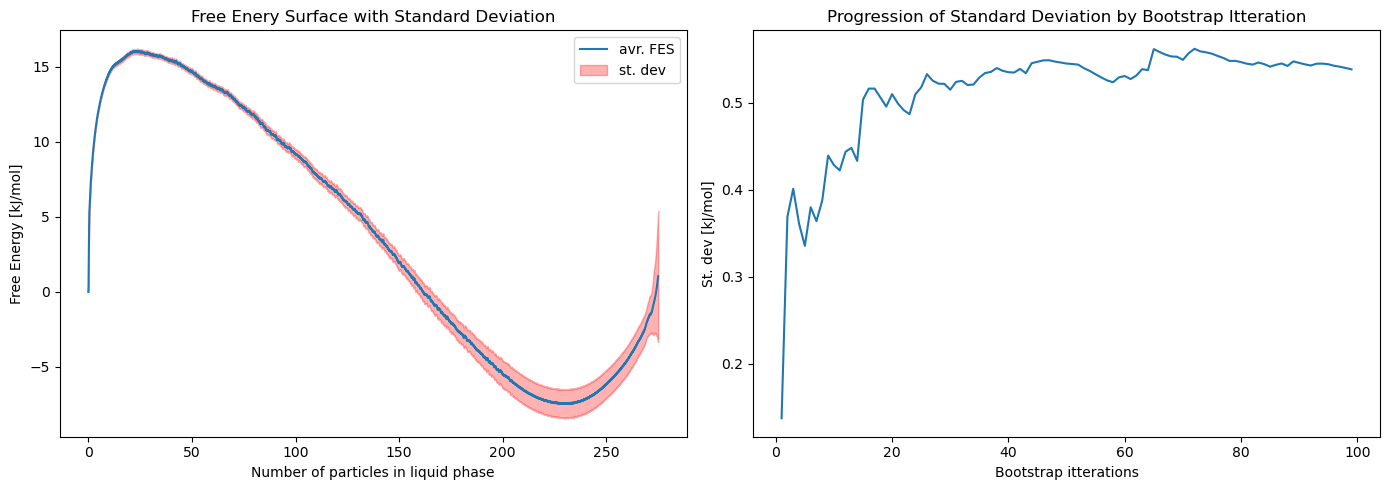

In [ ]:
os.chdir(path + "/DATA_examples/1D_LJ_T6n55")

#initialise force list and grid
force_array = []
min_grid=0; max_grid=275; nbins=2201; X = np.linspace(min_grid, max_grid, nbins)

#load force terms
for i in range(1,51):
    [Ftot_den, Ftot_den2, Ftot, ofv_num] = MFI1D.load_pkl(path_forceterms + "forces_forw_"+str(i))
    [Ftot_den_f, Ftot_den2_f, Ftot_f, ofv_num_f] = MFI1D.load_pkl(path_forceterms + "forces_back_"+str(i))
    force = np.asarray([[Ftot_den, Ftot], [Ftot_den_f, Ftot_f]])
    [Ftot_den, Ftot] = MFI1D.patch_forces(force)
    force_array.append( [Ftot_den, Ftot] )
    
#Boostrap
[FES_avr, sd_fes, sd_fes_prog ] = MFI1D.bootstrap_1D(X, np.asarray(force_array), n_bootstrap=100, set_fes_minima = "first_value")

#Plot
plt.figure(figsize=(14,5)); plt.subplot(1,2,1)
plt.plot(X, FES_avr, label="avr. FES")
plt.fill_between(X, FES_avr - sd_fes, FES_avr + sd_fes, alpha=0.3, color="red", label="st. dev")
plt.xlabel("Number of particles in liquid phase"), plt.ylabel("Free Energy [kJ/mol]"); plt.legend(); plt.title("Free Enery Surface with Standard Deviation")

plt.subplot(1,2,2)
plt.plot(range(len(sd_fes_prog)), sd_fes_prog)
plt.xlabel("Bootstrap itterations"), plt.ylabel("St. dev [kJ/mol]"); plt.title("Progression of Standard Deviation by Bootstrap Itteration"); plt.tight_layout()

